Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [89]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [90]:
## Mouting google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [91]:
# Unzipping the archive containing images.
!unzip gdrive/MyDrive/melanoma_assignment/CNN_assignment.zip

Archive:  gdrive/MyDrive/melanoma_assignment/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  


In [92]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [93]:
image_count_train = len(list(dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [94]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [95]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [96]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [97]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [98]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

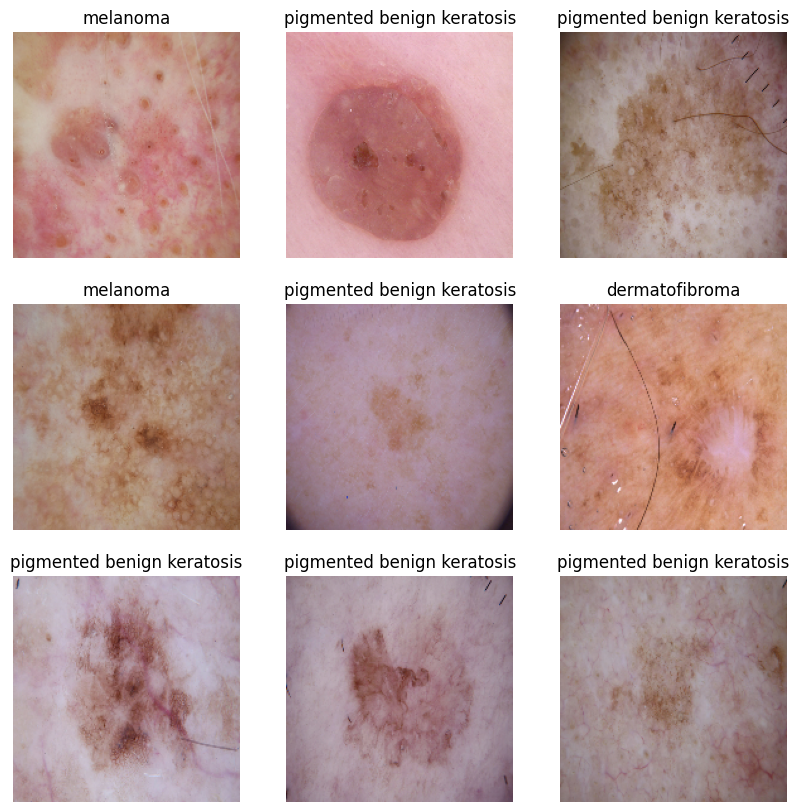

In [99]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(4):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [100]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model to predict 9 classes

In [101]:
### Your code goes here
num_classes = 9

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [102]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [103]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [104]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 81ms/step - loss: 2.0735 - accuracy: 0.1975 - val_loss: 2.0377 - val_accuracy: 0.2036
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.9446 - accuracy: 0.2684 - val_loss: 1.8531 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6666 - accuracy: 0.4258 - val_loss: 1.5214 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4340 - accuracy: 0.5017 - val_loss: 1.4495 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3014 - accuracy: 0.5485 - val_loss: 1.3964 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1902 - accuracy: 0.5787 - val_loss: 1.4170 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1043 - accuracy: 0.6010 - val_loss: 1.4419 - val_accuracy: 0.5257
Epoch 8/20
5

### Visualizing training results

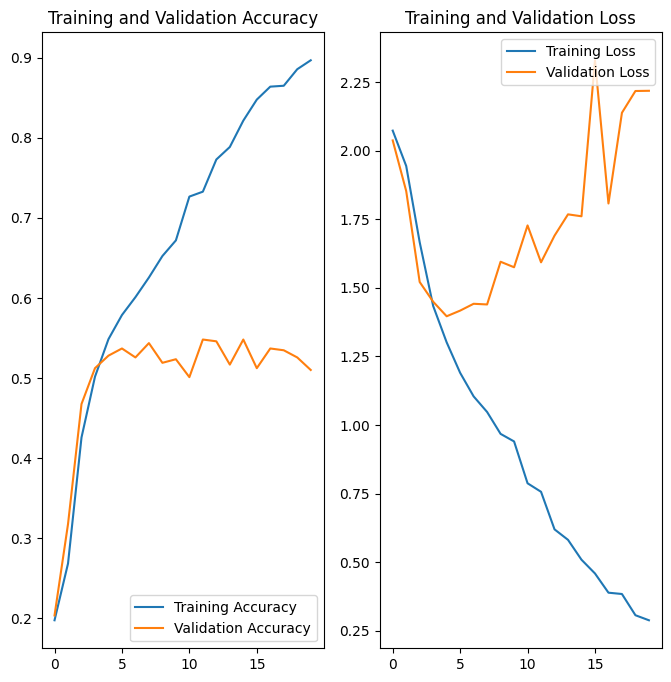

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations
In the plots above, the training accuracy increases till 89% but validation accuracy stops increasing after sometime. The final validation accuracy is 51%.

This indicates that the model is **overfitting** during the training and failed to cover the validation data/patterns.

Let's try increasing the data size (number of images) in the dataset using agumentation strategy.

In [106]:
# Creating augmentation Layer
data_augmentation_layer = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

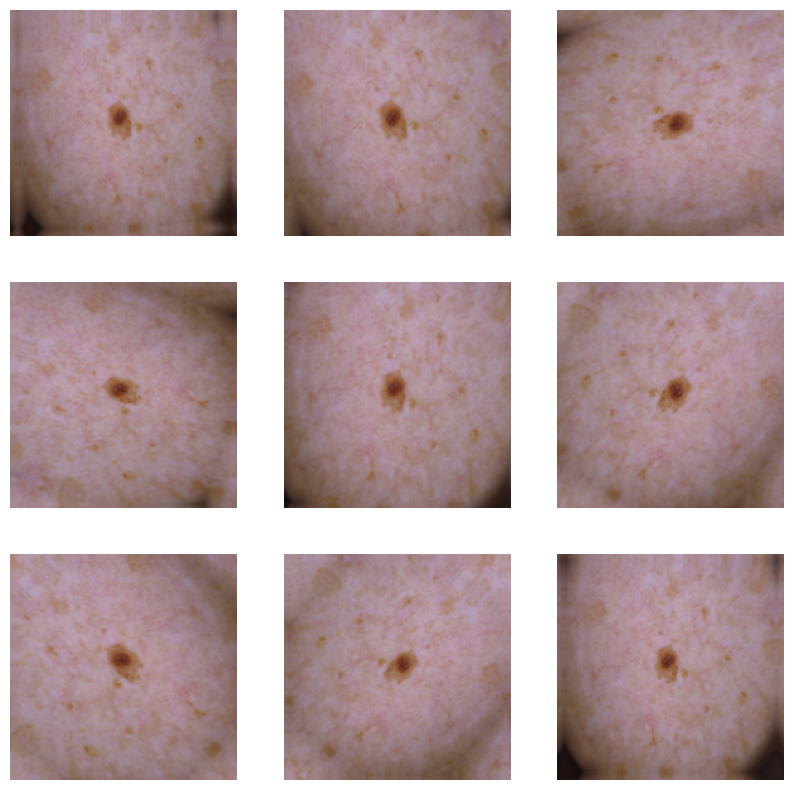

In [107]:
# Visualize the augmetned images for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [108]:
### Your code goes here
model = tf.keras.Sequential([
  data_augmentation_layer,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [110]:
# Let's train the model first with 20 epochs
#
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 33ms/step - loss: 1.8037 - accuracy: 0.3393 - val_loss: 1.7642 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5811 - accuracy: 0.4369 - val_loss: 1.5993 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4551 - accuracy: 0.4916 - val_loss: 1.4415 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.3999 - accuracy: 0.5028 - val_loss: 1.4065 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3508 - accuracy: 0.5279 - val_loss: 1.4175 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3538 - accuracy: 0.5089 - val_loss: 1.4473 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2898 - accuracy: 0.5346 - val_loss: 1.3361 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing the results

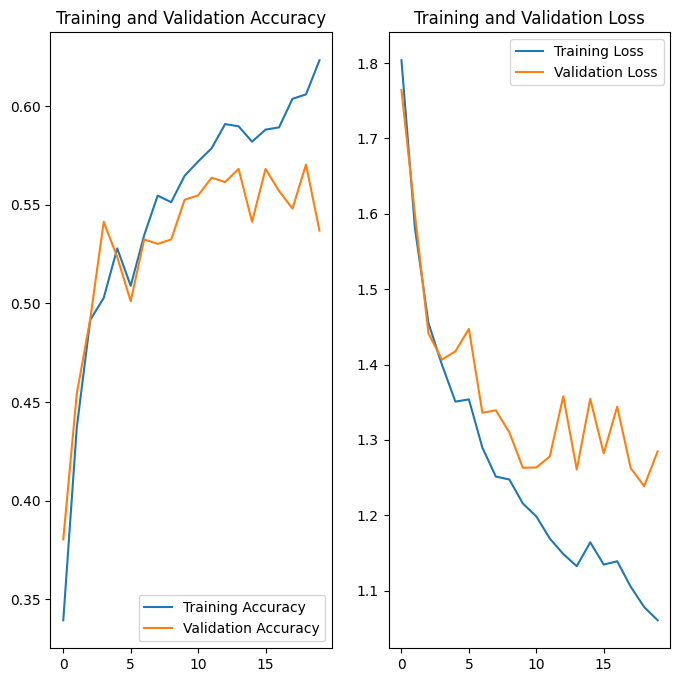

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As observed in the above charts, training and validation accuracy as increasing together. There difference beetween them is little but their values (62% and 53%) respectively are not impressive.

#### Low accuracy overall indicates that the model is underfitting.

Let's try increasing number of epochs and re-train the model.

In [112]:
### Creating model
model = tf.keras.Sequential([
  data_augmentation_layer,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [113]:
### Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [114]:
### Training the model with 30 epochs.
# Let's train the model first with 20 epochs
#
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 4s 32ms/step - loss: 2.0970 - accuracy: 0.2489 - val_loss: 1.9004 - val_accuracy: 0.2685
Epoch 2/30
56/56 [==============================] - 2s 29ms/step - loss: 1.7693 - accuracy: 0.3555 - val_loss: 1.7281 - val_accuracy: 0.3736
Epoch 3/30
56/56 [==============================] - 2s 31ms/step - loss: 1.5633 - accuracy: 0.4498 - val_loss: 1.5351 - val_accuracy: 0.4877
Epoch 4/30
56/56 [==============================] - 2s 29ms/step - loss: 1.4494 - accuracy: 0.4855 - val_loss: 1.6117 - val_accuracy: 0.4653
Epoch 5/30
56/56 [==============================] - 2s 29ms/step - loss: 1.4857 - accuracy: 0.4805 - val_loss: 1.4572 - val_accuracy: 0.4966
Epoch 6/30
56/56 [==============================] - 2s 29ms/step - loss: 1.4127 - accuracy: 0.5134 - val_loss: 1.4374 - val_accuracy: 0.4966
Epoch 7/30
56/56 [==============================] - 2s 29ms/step - loss: 1.3778 - accuracy: 0.5112 - val_loss: 1.4069 - val_accuracy: 0.5078
Epoch 8/30
56

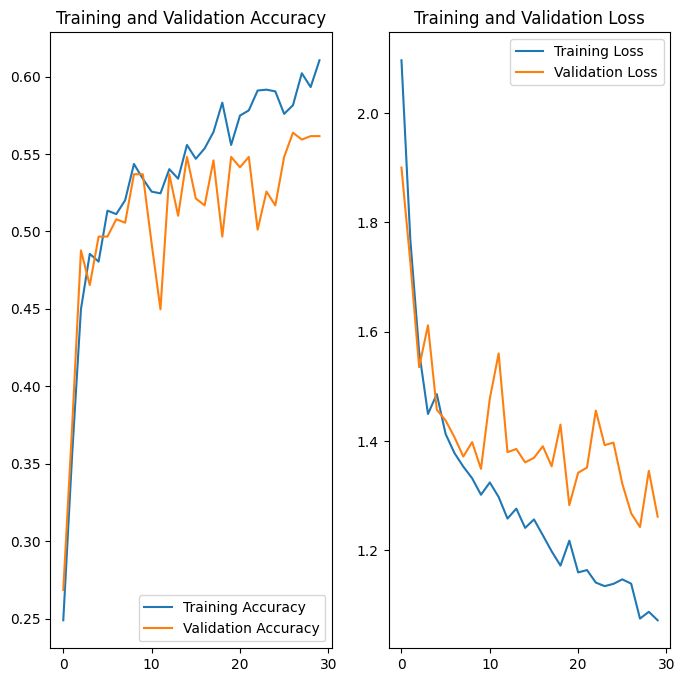

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Increasing number of epochs seems helping but results are not impressive.Overall accuracy of the model is still very low. It seems the model is still underfigging.

There may be an imbalance between classes in the dataset. Let's check the distribution of the classes in the data.

### Verifying the class imbalance by checking distribution of classes in training dataset.

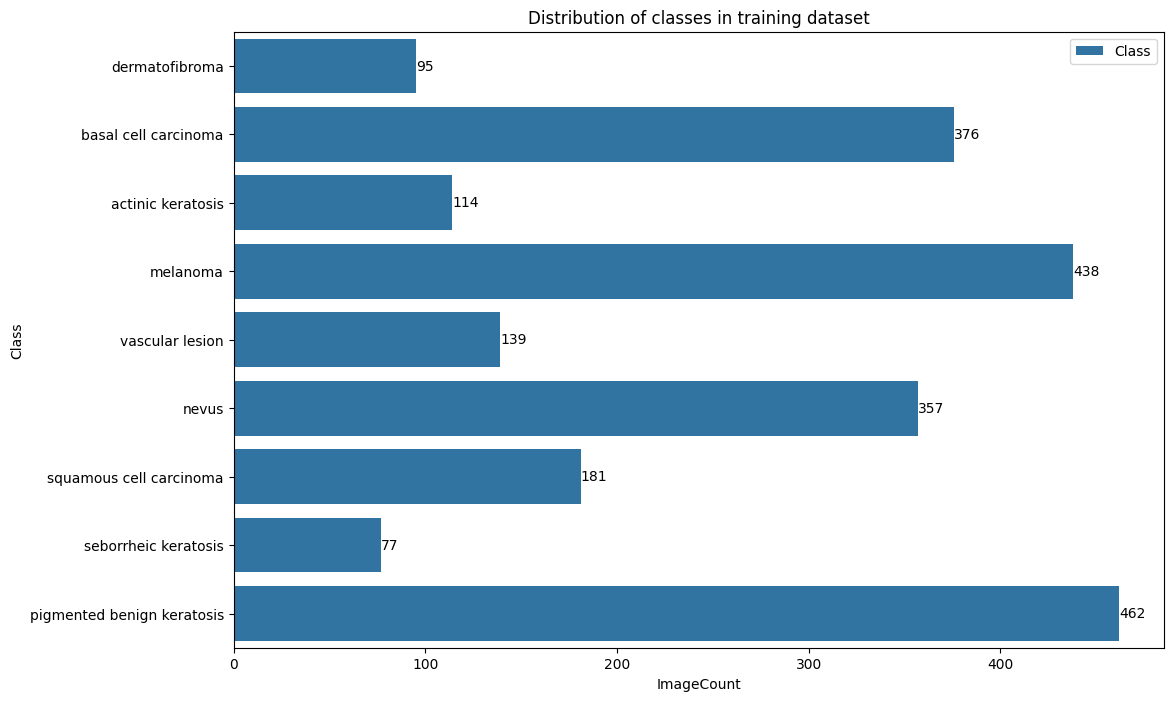

In [116]:
#counting number of image in each classes
count= []
for path in pathlib.Path(dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(dir_train)
                if os.path.isdir(os.path.join(dir_train, name))]

#return dataframe with image count and class.
class_images_df = pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'ImageCount'])

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="ImageCount", y="Class", data=class_images_df, label="Class")
ax.bar_label(ax.containers[0])
plt.title('Distribution of classes in training dataset')
plt.show()

### Observations

The distribution chart above shows that the classes do not have equal amount of data.
Seborrheic kratosis has the lesst number of samples which is 77 whilc pegmented benign keratosis has 462 samples. The difference is large.

Let's take care of this class imbalance by using Augmentor


In [117]:
!pip install Augmentor

In [118]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EC670203DF0>: 100%|██████████| 500/500 [00:20<00:00, 24.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC67060DE10>: 100%|██████████| 500/500 [00:21<00:00, 23.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC670767A30>: 100%|██████████| 500/500 [00:19<00:00, 25.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7EC6707C5B40>: 100%|██████████| 500/500 [01:17<00:00,  6.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC67035A440>: 100%|██████████| 500/500 [01:03<00:00,  7.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC73E8D2410>: 100%|██████████| 500/500 [00:16<00:00, 30.89 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EC6706D6530>: 100%|██████████| 500/500 [00:38<00:00, 13.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC7E0D3E500>: 100%|██████████| 500/500 [00:17<00:00, 28.98 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC6707675E0>: 100%|██████████| 500/500 [00:17<00:00, 28.99 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [119]:
image_count_train = len(list(dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Distribution of augmented data after adding new images to the original training data.

In [120]:
path_list = [x for x in glob(os.path.join(dir_train, '*','output', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(dir_train, '*', '*.jpg'))]
len(path_list)

4500

In [121]:
path_dataframe_dict = dict(zip(path_list, lesion_list))
path_df = pd.DataFrame(list(path_dataframe_dict.items()),columns = ['Path','Label'])
path_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
1,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
3,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2235,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2236,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2237,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis


In [122]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [123]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [124]:
temp_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

new_path_df = pd.concat([path_df, temp_df], ignore_index=True)
# new_path_df = path_df.append(df_dataframe_dict_newtemp)
new_path_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
1,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
3,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


In [125]:
new_path_df.shape

(6739, 2)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [126]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [128]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [130]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating new model

In [131]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [132]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compiling the model

In [133]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#### Training the model

In [134]:
# Let's train the model with 30 epchos first.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 30s 56ms/step - loss: 1.8997 - accuracy: 0.2708 - val_loss: 1.6109 - val_accuracy: 0.3905
Epoch 2/30
169/169 [==============================] - 5s 30ms/step - loss: 1.4748 - accuracy: 0.4418 - val_loss: 1.3741 - val_accuracy: 0.4662
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 1.2709 - accuracy: 0.5135 - val_loss: 1.1839 - val_accuracy: 0.5538
Epoch 4/30
169/169 [==============================] - 4s 26ms/step - loss: 1.1205 - accuracy: 0.5862 - val_loss: 1.0916 - val_accuracy: 0.5895
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 0.9617 - accuracy: 0.6510 - val_loss: 0.9866 - val_accuracy: 0.6385
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 0.8349 - accuracy: 0.6912 - val_loss: 0.9075 - val_accuracy: 0.6704
Epoch 7/30
169/169 [==============================] - 4s 26ms/step - loss: 0.7273 - accuracy: 0.7276 - val_loss: 0.8290 - val_accuracy: 0.717

#### Visualize the model results

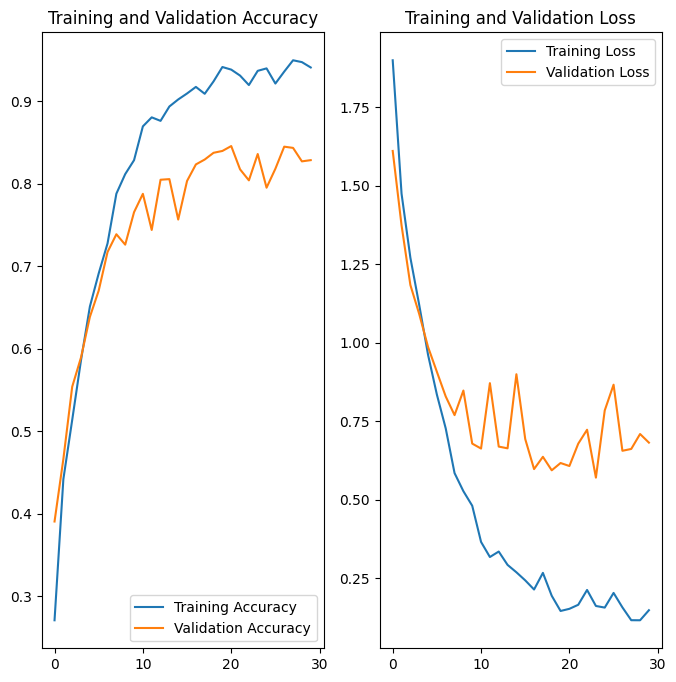

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:

Handling of class imbalance has visible impact on the model quality. Training accuracy and validation accuracy are improve significantly.

Both training accuracy and validation accuracy are increasing linearly.
Training accurary has increased to 94% and validation accuracy has incrased to 82%.

Both overfitting and underfitting issues seem to be resolved at this stage.

### Test the model

Let's test the model using test data.

1/1 [==============================] - 1s 613ms/step
Actual Class: basal cell carcinoma
Predictive Class: squamous cell carcinoma


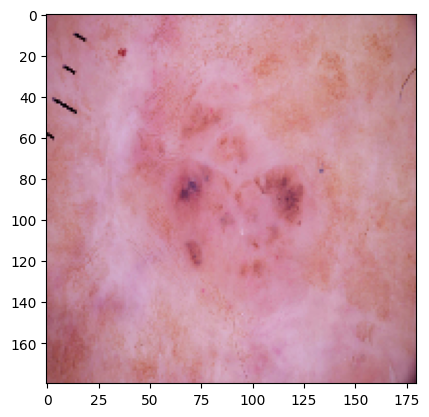

In [136]:
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)